# ML with Pyspark: Clustering of players based on their stats per 90 minutes

## Data processing

In [73]:
# pyuspark session

from pyspark.sql import SparkSession

spark = SparkSession.builder \
               .appName('ml') \
               .getOrCreate()

In [ ]:
# approach 1
import os
from pyspark.sql.functions import lit

# Path to the folder where the CSVs are stored
folder_path = "../data/football-players-DB/"

# List of all CSV files
csv_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith(".csv")]

# Initialize an empty DataFrame to store the final concatenated result
final_df = None
schema = None

# Iterate over each CSV file
for i, file in enumerate(csv_files):
    file_name = os.path.basename(file)  # Get the file name without the path
    print(f"Processing file {i+1}/{len(csv_files)}: {file_name}")
    
    # Extract the season from the last 4 or 5 characters of the file name (without the '.csv')
    season = file_name[-9:-4] if "-" in file_name[-9:-4] else file_name[-8:-4]
    print(f"Detected season: {season}")
    
    # Read each CSV file with schema inference
    df = spark.read.csv(file, header=True, inferSchema=True)
    
    # Add a new column 'season' with the extracted season value using lit()
    df = df.withColumn("season", lit(season))
    
    # If it's the first file, use its schema as the base schema
    if schema is None:
        schema = df.schema
        final_df = df
    else:
        # Check if the current file has the same schema as the base schema
        if df.schema == schema:
            # Concatenate the DataFrame if the schema matches
            final_df = final_df.unionByName(df)
        else:
            print(f"Schema mismatch found in file: {file_name}")
            # Optionally handle the mismatch by adjusting the schema

Processing file 1/888: 1. HNL 20-21.csv
Detected season: 20-21
Processing file 2/888: 1. HNL 21-22.csv
Detected season: 21-22
Schema mismatch found in file: 1. HNL 21-22.csv
Processing file 3/888: 1. HNL 22-23.csv
Detected season: 22-23
Processing file 4/888: 1. HNL 23-24.csv
Detected season: 23-24
Schema mismatch found in file: 1. HNL 23-24.csv
Processing file 5/888: 1. HNL 24-25.csv
Detected season: 24-25
Schema mismatch found in file: 1. HNL 24-25.csv
Processing file 6/888: 2. Bundesliga 20-21.csv
Detected season: 20-21
Processing file 7/888: 2. Bundesliga 21-22.csv
Detected season: 21-22
Processing file 8/888: 2. Bundesliga 22-23.csv
Detected season: 22-23
Schema mismatch found in file: 2. Bundesliga 22-23.csv
Processing file 9/888: 2. Bundesliga 23-24.csv
Detected season: 23-24
Schema mismatch found in file: 2. Bundesliga 23-24.csv
Processing file 10/888: 2. Bundesliga 24-25.csv
Detected season: 24-25
Schema mismatch found in file: 2. Bundesliga 24-25.csv
Processing file 11/888: 2

In [8]:
spark.stop()

In [1]:
# approach 2: Concatenate csv's that have the same schema until only 1 dataframe is created
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType
from pyspark.sql.functions import lit
import os

spark = SparkSession.builder \
    .appName("Unificar CSVs de Futbol") \
    .config("spark.driver.memory", "12g") \
    .config("spark.executor.memory", "4g") \
    .config("spark.sql.execution.arrow.pyspark.enabled", "true") \
    .getOrCreate()

In [5]:
import re

# path to the folder where the CSVs are stored
folder_path = "../data/football-players-DB/"
csv_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith(".csv")]


# Function to load a CSV file and get its schema and add 'season' and 'league' columns

def load_and_get_schema(file_path):
    # Extract the file name without the path and without the ".csv" extension
    file_name = os.path.basename(file_path).replace(".csv", "")
    
    # Use regex to check if season is in "XX-XX" or "XXXX" format
    season_match = re.search(r'(\d{2}-\d{2}|\d{4})$', file_name)
    
    if season_match:
        season = season_match.group(0)  # Capture the exact season format as it appears
        league = file_name[:-(len(season) + 1)].strip()  # Everything before season as "league"
    else:
        raise ValueError(f"Unexpected format in file name: {file_name}")

    # Load the DataFrame with schema inference
    df = spark.read.option("header", "true").option("escape", '"').csv(file_path)
    
    # Add "season" and "league" columns
    df = df.withColumn("season", lit(season)).withColumn("league", lit(league))
    
    return df, df.schema



# Lists to store DataFrames and schemas
dataframes = []
schemas = []

# Grouping files with the same schema iteratively
standby_files = csv_files.copy()
round_counter = 1

print(f"Total archivos a procesar: {len(standby_files)}")

while standby_files:
    print(f"\n--- Comienzo de ronda {round_counter} ---")
    print(f"Archivos pendientes: {len(standby_files)}")

    # Take the first file as the reference schema
    ref_file = standby_files.pop(0)
    ref_df, ref_schema = load_and_get_schema(ref_file)
    print(f"Usando esquema de referencia del archivo: {os.path.basename(ref_file)}")

    # Lists to store matched DataFrames and remaining files
    matched_dfs = [ref_df]
    remaining_files = []
    
    # Try to match the schema of the reference file with other files
    for i, file in enumerate(standby_files, start=1):
        df, schema = load_and_get_schema(file)
        if schema == ref_schema:
            matched_dfs.append(df)
            print(f"Archivo compatible encontrado: {os.path.basename(file)} ({i}/{len(standby_files)})")
        else:
            remaining_files.append(file)
    
    # Union of all matched DataFrames
    unified_df = matched_dfs[0]
    for df in matched_dfs[1:]:
        unified_df = unified_df.unionByName(df, allowMissingColumns=True)
    
    # Store the unified DataFrame and schema
    dataframes.append(unified_df)
    schemas.append(ref_schema)
    
    print(f"Total archivos unidos en esta ronda: {len(matched_dfs)}")
    print(f"Archivos restantes después de esta ronda: {len(remaining_files)}")

    # Update the standby files for the next round
    standby_files = remaining_files
    round_counter += 1

print("\n--- Finalización de agrupación iterativa ---")
print(f"Total de grupos de DataFrames: {len(dataframes)}")
print("Iniciando unificación final...")

# final unification
from pyspark.sql import functions as F

# Column normalization before final unification
all_columns = set(col for df in dataframes for col in df.columns)

for i, df in enumerate(dataframes, start=1):
    missing_cols = all_columns - set(df.columns)
    for col in missing_cols:
        dataframes[i-1] = df.withColumn(col, lit(None))  # Add dummy columns with None values if missing
    
    # Rename similar columns with different names
    if "Aerial duels per 90" in df.columns:
        dataframes[i-1] = df.withColumnRenamed("Aerial duels per 90", "Aerial_Duels_per_90")
    
    print(f"DataFrame {i}/{len(dataframes)} normalizado con columnas faltantes añadidas.")

# Final unification of all DataFrames
final_df = dataframes[0]
for i, df in enumerate(dataframes[1:], start=2):
    final_df = final_df.unionByName(df, allowMissingColumns=True)
    print(f"DataFrame {i}/{len(dataframes)} unido al DataFrame final.")

# Shor last schema and data
print("\n--- Esquema final ---")
final_df.printSchema()
print("\n--- Muestra de los datos unificados ---")
final_df.show(5)
print("\nUnificación completa de todos los archivos.")

Total archivos a procesar: 888

--- Comienzo de ronda 1 ---
Archivos pendientes: 888
Usando esquema de referencia del archivo: 1. HNL 20-21.csv
Archivo compatible encontrado: 1. HNL 21-22.csv (1/887)
Archivo compatible encontrado: 1. HNL 22-23.csv (2/887)
Archivo compatible encontrado: 1. HNL 24-25.csv (4/887)
Archivo compatible encontrado: 2. Bundesliga 20-21.csv (5/887)
Archivo compatible encontrado: 2. Bundesliga 21-22.csv (6/887)
Archivo compatible encontrado: 2. Bundesliga 22-23.csv (7/887)
Archivo compatible encontrado: 2. Bundesliga 24-25.csv (9/887)
Archivo compatible encontrado: 2. HNL 20-21.csv (10/887)
Archivo compatible encontrado: 2. HNL 21-22.csv (11/887)
Archivo compatible encontrado: 2. HNL 22-23.csv (12/887)
Archivo compatible encontrado: 2. HNL 24-25.csv (14/887)
Archivo compatible encontrado: 3. Liga 20-21.csv (15/887)
Archivo compatible encontrado: 3. Liga 21-22.csv (16/887)
Archivo compatible encontrado: 3. Liga 22-23.csv (17/887)
Archivo compatible encontrado: 3. 

In [35]:
final_df.printSchema()

root
 |-- Player: string (nullable = true)
 |-- Full name: string (nullable = true)
 |-- Wyscout id: string (nullable = true)
 |-- Team: string (nullable = true)
 |-- Team within selected timeframe: string (nullable = true)
 |-- Team logo: string (nullable = true)
 |-- Competition: string (nullable = true)
 |-- Position: string (nullable = true)
 |-- Primary position: string (nullable = true)
 |-- Primary position, %: string (nullable = true)
 |-- Secondary position: string (nullable = true)
 |-- Secondary position, %: string (nullable = true)
 |-- Third position: string (nullable = true)
 |-- Third position, %: string (nullable = true)
 |-- Age: string (nullable = true)
 |-- Birthday: string (nullable = true)
 |-- Market value: string (nullable = true)
 |-- Contract expires: string (nullable = true)
 |-- Matches played: string (nullable = true)
 |-- Minutes played: string (nullable = true)
 |-- Goals: string (nullable = true)
 |-- xG: string (nullable = true)
 |-- Assists: string (nul

In [18]:
final_df.show()

+------------+--------------------+----------+---------------+------------------------------+--------------------+-------------+-----------------+----------------+-------------------+------------------+---------------------+--------------+-----------------+---+----------+------------+----------------+--------------+--------------+-----+------------------+-------+----+------------+------------+-------------+----------------+-----+------+------+-------+-----------------------------------+----------------------+----------------------+---------------------+-------------------+----------------------+--------------------+--------------------+--------------------+------------------+-------------------+------------+-------------------+---------+----------------+-----------------------------------+------------------+-----------------+------------------------+---------+----------+-----------------+-----+------------------+------------------+------------------+--------------+-------------------+-

In [26]:
# show random 20 rows
final_df.sample(fraction=0.01, seed = 42).limit(20).show()

+----------------+--------------------+----------+------------------+------------------------------+--------------------+-------------+------------------+----------------+-------------------+------------------+---------------------+--------------+-----------------+----+----------+------------+----------------+--------------+--------------+-----+----+-------+-----+------------+------------+-------------+--------------------+-----+------+------+-------+-----------------------------------+----------------------+----------------------+---------------------+-------------------+----------------------+--------------------+--------------------+--------------------+------------------+------------+------------+-------------------+---------+----------------+-----------------------------------+------------+-----------------+------------------------+---------+----------+-----------------+-----+------------+------------------+------------------+--------------+--------------+-------------------+-----

In [8]:
# how many times each player appears in the dataset
#final_df.groupBy("Player").count().show()

# how many times each player appears in the dataset on average
final_df.groupBy("Player").count().agg({"count": "avg"}).show()

+-----------------+
|       avg(count)|
+-----------------+
|3.192070292643962|
+-----------------+



In [20]:
# count total number of rows
print(f"Total number of rows: {final_df.count()}")
# count total number of columns
print(f"Total number of columns: {len(final_df.columns)}")

Total number of rows: 439580
Total number of columns: 130


In [21]:
# Fprint all values from the 'season' column
final_df.select("season").distinct().show()

+------+
|season|
+------+
| 20-21|
| 21-22|
| 22-23|
| 24-25|
|  2020|
|  2021|
|  2022|
|  2023|
|  2024|
| 23-24|
+------+



In [24]:
# show all data from 'Rominigue Kouamé N'Guessan' in the midfielders subset
final_df.filter(F.col("Full name") == "Rominigue Kouamé N'Guessan" ).show()

+---------+--------------------+----------+-----+------------------------------+--------------------+----------------+-----------------+----------------+-------------------+------------------+---------------------+--------------+-----------------+----+----------+------------+----------------+--------------+--------------+-----+----+-------+----+------------+------------+-------------+--------------------+----+------+------+-------+-----------------------------------+----------------------+----------------------+---------------------+-------------------+----------------------+--------------------+--------------------+--------------------+------------------+------------+------------+-------------------+---------+----------------+-----------------------------------+------------+-----------------+------------------------+---------+----------+-----------------+-----+------------+------------------+------------------+--------------+--------------+-------------------+-------------------------

### convert columns to float type|

In [6]:
from pyspark.sql.functions import col, to_date
from pyspark.sql.types import FloatType

# List of columns to keep as string
string_columns = [
    "Player", "Full name", "Wyscout id", "Team", "Team within selected timeframe",
    "Team logo", "Competition", "Position", "Primary position",
    "Secondary position", "Third position",
    "Birth country", "Passport country", "Foot", "On loan",
    "season", "league"
]

# Step 1: Rename columns only if they contain a "." to replace it with "_"
for old_col in final_df.columns:
    if '.' in old_col:
        new_col = old_col.replace(".", "_")
        final_df = final_df.withColumnRenamed(old_col, new_col)

# Update the list of string columns with new names for columns that had "." replaced by "_"
string_columns = [col.replace(".", "_") if "." in col else col for col in string_columns]

# Step 2: Convert "Birthday" and "Contract expires" to DateType using to_date
final_df = final_df.withColumn("Birthday", to_date("Birthday", "yyyy-MM-dd"))
final_df = final_df.withColumn("Contract expires", to_date("Contract expires", "yyyy-MM-dd"))

# Step 3: Convert all other columns to float, if they are not in the string_columns list
for column in final_df.columns:
    if column not in string_columns and column not in ["Birthday", "Contract expires"]:
        print(f"Processing column: {column}")
        try:
            # Directly cast to FloatType, non-numeric values will become NULL
            final_df = final_df.withColumn(column, col(column).cast(FloatType()))
            print(f"Column {column} converted to FloatType successfully.")
        except Exception as e:
            print(f"Error converting column {column} to FloatType: {e}")
            break  # Stop the loop if an error is encountered

# Show schema to verify the changes
final_df.printSchema()



Processing column: Primary position, %
Column Primary position, % converted to FloatType successfully.
Processing column: Secondary position, %
Column Secondary position, % converted to FloatType successfully.
Processing column: Third position, %
Column Third position, % converted to FloatType successfully.
Processing column: Age
Column Age converted to FloatType successfully.
Processing column: Market value
Column Market value converted to FloatType successfully.
Processing column: Matches played
Column Matches played converted to FloatType successfully.
Processing column: Minutes played
Column Minutes played converted to FloatType successfully.
Processing column: Goals
Column Goals converted to FloatType successfully.
Processing column: xG
Column xG converted to FloatType successfully.
Processing column: Assists
Column Assists converted to FloatType successfully.
Processing column: xA
Column xA converted to FloatType successfully.
Processing column: Duels per 90
Column Duels per 90 c

### Save the final DataFrame to a single CSV file

In [7]:
# Disable Arrow optimization
spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "false")

# Convert the Spark DataFrame to Pandas
final_df_pandas = final_df.toPandas()

# Save the final Pandas DataFrame to a CSV file
final_df_pandas.to_csv("../App - Project/data/football-players-DB.csv", index=False)

In [79]:
# dropping where Primary position == 'GK'
final_df = final_df.filter(final_df['Primary position'] != 'GK')
# filter only season == 2024 and 24-25
final_df = final_df.filter((final_df['season'] == '2024') | (final_df['season'] == '24-25'))
# create another pyspark dataframe with only certain columns to train a clusering model
# columns to drop: 'Player', 'Wyscout id', 'Team', 'Team within selected timeframe', 'Team logo', 'Competition', 'Position', 'Primary position', 'Primary position, %', 'Secondary position', 'Secondary position, %', 'Third position', 'Third position, %', 'Age', 'Birthday', 'Market value', 'Contract expires',  'Birth country' ,'Passport country', 'On loan', 'season', 'Foot'
df_clustering = final_df.drop('Player', 'Wyscout id', 'Team', 'Team within selected timeframe', 'Team logo', 'Competition', 'Position', 'Primary position', 'Primary position, %', 'Secondary position', 'Secondary position, %', 'Third position', 'Third position, %', 'Age', 'Birthday', 'Market value', 'Contract expires',  'Birth country' ,'Passport country', 'On loan', 'season', 'Foot', 'Prevented goals', 'Prevented goals per 90', 'Shots against per 90', 'Conceded goals per 90', 'Exits per 90')

In [80]:
df_clustering.show()

+--------------------+--------------+--------------+-----+------------------+-------+------------------+------------+------------+------+------+-----------------------------------+----------------------+----------------------+---------------------+-------------------+----------------------+--------------------+--------------------+--------------------+------------------+------------------+------------+-------------------+---------+----------------+-----------------------------------+------------+-----------------+------------------------+---------+----------+-----------------+-----+-------------------+------------------+------------------+--------------+--------------+-------------------+------------------------------+-----------------------------------+-------------------------------+------------------------------------+----------------------------+------------------+----------------------+----------------------+----------------------+---------------------+-----------------------+----

In [81]:
# count total number of rows
print(f"Total number of rows: {df_clustering.count()}")
# count total number of columns
print(f"Total number of columns: {len(df_clustering.columns)}")

Total number of rows: 3157
Total number of columns: 100


In [82]:
# identify the columns with missing values
missing_values = {col: df_clustering.filter(df_clustering[col].isNull()).count() for col in df_clustering.columns}
missing_values

{'Full name': 0,
 'Matches played': 0,
 'Minutes played': 0,
 'Goals': 0,
 'xG': 0,
 'Assists': 0,
 'xA': 0,
 'Duels per 90': 232,
 'Duels won, %': 232,
 'Height': 0,
 'Weight': 0,
 'Successful defensive actions per 90': 232,
 'Defensive duels per 90': 232,
 'Defensive duels won, %': 232,
 'Aerial duels per 9035': 232,
 'Aerial duels won, %': 232,
 'Sliding tackles per 90': 232,
 'PAdj Sliding tackles': 0,
 'Shots blocked per 90': 232,
 'Interceptions per 90': 232,
 'PAdj Interceptions': 0,
 'Fouls per 90': 232,
 'Yellow cards': 0,
 'Yellow cards per 90': 232,
 'Red cards': 0,
 'Red cards per 90': 232,
 'Successful attacking actions per 90': 232,
 'Goals per 90': 232,
 'Non-penalty goals': 0,
 'Non-penalty goals per 90': 232,
 'xG per 90': 232,
 'Head goals': 0,
 'Head goals per 90': 232,
 'Shots': 0,
 'Shots per 90': 232,
 'Shots on target, %': 232,
 'Goal conversion, %': 0,
 'Assists per 90': 232,
 'Crosses per 90': 232,
 'Accurate crosses, %': 232,
 'Crosses from left flank per 90':

In [83]:
# drop rows with missing values
df_clustering = df_clustering.dropna()
# count total number of rows
print(f"Total number of rows: {df_clustering.count()}")

Total number of rows: 2925


In [84]:
# show scheme
df_clustering.printSchema()

root
 |-- Full name: string (nullable = true)
 |-- Matches played: integer (nullable = true)
 |-- Minutes played: integer (nullable = true)
 |-- Goals: integer (nullable = true)
 |-- xG: double (nullable = true)
 |-- Assists: integer (nullable = true)
 |-- xA: double (nullable = true)
 |-- Duels per 90: double (nullable = true)
 |-- Duels won, %: double (nullable = true)
 |-- Height: integer (nullable = true)
 |-- Weight: integer (nullable = true)
 |-- Successful defensive actions per 90: double (nullable = true)
 |-- Defensive duels per 90: double (nullable = true)
 |-- Defensive duels won, %: double (nullable = true)
 |-- Aerial duels per 9035: double (nullable = true)
 |-- Aerial duels won, %: double (nullable = true)
 |-- Sliding tackles per 90: double (nullable = true)
 |-- PAdj Sliding tackles: double (nullable = true)
 |-- Shots blocked per 90: double (nullable = true)
 |-- Interceptions per 90: double (nullable = true)
 |-- PAdj Interceptions: double (nullable = true)
 |-- Foul

## Model training and evaluation

In [85]:
import threading
from pyspark.ml.feature import VectorAssembler, StandardScaler

# Step 1: Select only the numeric columns, excluding "Full name"
feature_columns = [col for col in df_clustering.columns if col != "Full name"]

# Step 2: Prepare the feature vector with the selected numeric columns
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
df_features = assembler.transform(df_clustering)

# Step 3: Scale the features to improve clustering stability
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withStd=True, withMean=False)
scaler_model = scaler.fit(df_features)
df_scaled = scaler_model.transform(df_features)

In [86]:
import threading
import mlflow
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

# Step 4: Configure and train the KMeans model
# Set up KMeans with parameters
kmeans = KMeans(featuresCol="scaled_features", k=10, maxIter=20, tol=1e-4, seed=42, initMode="k-means||", initSteps=2)

# Define a function to fit the model
def fit_model():
    global model
    model = kmeans.fit(df_scaled)

# Start a thread for training
training_thread = threading.Thread(target=fit_model)
training_thread.start()

# Wait for 2 minutes (120 seconds)
training_thread.join(timeout=120)

# Check if the training is still ongoing
if training_thread.is_alive():
    print("Training stopped due to time limit.")
    # Optionally handle the case where training exceeded the limit
else:
    print("Training completed within the time limit.")
    # Evaluate and log metrics in MLflow
    with mlflow.start_run():
        mlflow.log_param("k", 10)
        mlflow.log_param("maxIter", 20)
        mlflow.log_param("tol", 1e-4)
        mlflow.log_param("seed", 42)
        mlflow.log_param("initMode", "k-means||")
        mlflow.log_param("initSteps", 2)
        mlflow.log_param("distanceMeasure", "euclidean")
        mlflow.log_param("predictionCol", "prediction")
        mlflow.log_param("featuresCol", "scaled_features")
        
        predictions = model.transform(df_scaled)
        evaluator = ClusteringEvaluator(featuresCol="scaled_features", predictionCol="prediction", metricName="silhouette")
        silhouette_score = evaluator.evaluate(predictions)
        
        mlflow.log_metric("silhouette_score", silhouette_score)
        print(f"Silhouette Score: {silhouette_score}")

Training completed within the time limit.
Silhouette Score: 0.02058529638032386


## Visualize the clustering results

In [87]:
# Show a sample of the resulting DataFrame with player names and assigned clusters
predictions.select("Full name", "prediction").show(10)

+--------------------+----------+
|           Full name|prediction|
+--------------------+----------+
|Diego Cristiano E...|         8|
|Willian Estefani ...|         0|
|Daniel de Oliveir...|         1|
|Carlos Gilberto N...|         0|
|Natanael Moreira ...|         8|
|Alesson dos Santo...|         9|
|Adilson Dos Anjos...|         9|
| Bruno Ferreira Melo|         0|
|Miquéias Cabral E...|         8|
|      Alexandre Egea|         0|
+--------------------+----------+
only showing top 10 rows



In [88]:
# Distribution of players by clusters
cluster_distribution = predictions.groupBy("prediction").count()
cluster_distribution.show()

+----------+-----+
|prediction|count|
+----------+-----+
|         1|  221|
|         6|  363|
|         3|  162|
|         5|  276|
|         9|  279|
|         4|   79|
|         8|  591|
|         7|  220|
|         2|  411|
|         0|  323|
+----------+-----+



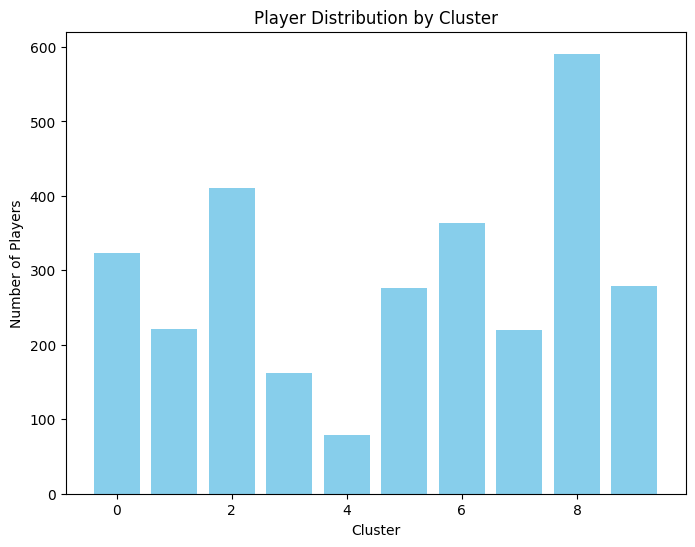

In [89]:
import matplotlib.pyplot as plt

# Collect the cluster distribution for plotting
cluster_counts = cluster_distribution.toPandas()
plt.figure(figsize=(8, 6))
plt.bar(cluster_counts['prediction'], cluster_counts['count'], color='skyblue')
plt.xlabel("Cluster")
plt.ylabel("Number of Players")
plt.title("Player Distribution by Cluster")
plt.show()

## Alternative Approach: PCA for dimensionality reduction before K-Means

It is found in literature that PCA works well with clustering by K-means.
Also in previous works of my own I've found that 20 components is a proper number for this dataset.

+--------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|Full name                       |pca_features                                                                                                                                                                                                                                                                                                                                                                                        |
+--------------------------------+----------------------------------------------------------------------------------------------------------------------

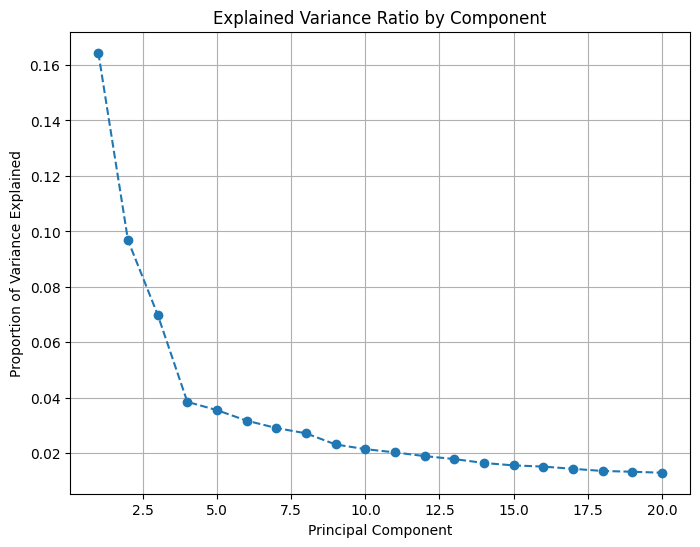

+--------------------+--------------------+
|           Full name|        pca_features|
+--------------------+--------------------+
|Diego Cristiano E...|[10.7994465532687...|
|Willian Estefani ...|[14.1771841646026...|
|Daniel de Oliveir...|[8.76776562488502...|
|Carlos Gilberto N...|[11.9887525996505...|
|Natanael Moreira ...|[9.05999490014314...|
|Alesson dos Santo...|[1.68667210836509...|
|Adilson Dos Anjos...|[6.47673577565866...|
| Bruno Ferreira Melo|[12.3422559710455...|
|Miquéias Cabral E...|[9.41937908135964...|
|      Alexandre Egea|[10.1220155057019...|
|Wallace Reis da S...|[13.0254079209501...|
|Luiz Otávio da Si...|[13.3124237984571...|
|Elias Lira Noguei...|[6.85023475802451...|
|João Victor Carro...|[13.1577930562620...|
|Lucas Ramon Batis...|[9.70235123825183...|
|Marcos Vinicius d...|[8.52371917063759...|
|Erick Da Costa Fa...|[0.42826735917140...|
|Éder Ferreira Gra...|[14.7244722237036...|
|Cristiano Claudin...|[11.0737847583849...|
|     Tiago Pagnussat|[12.554552

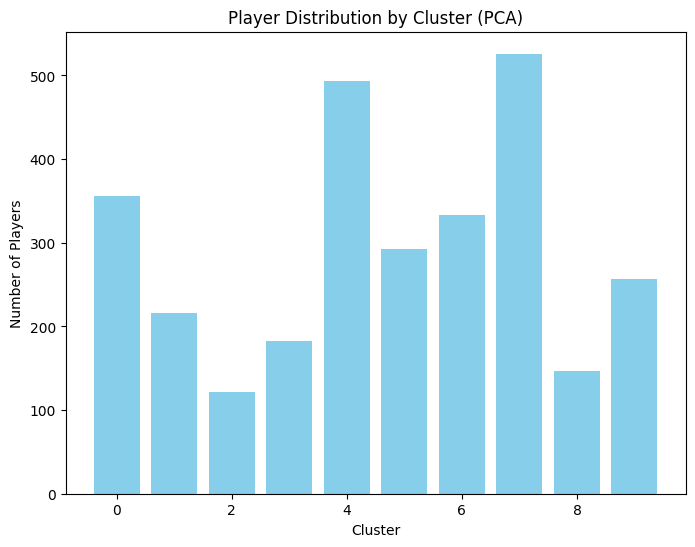

In [90]:
# perform PCA to reduce the dimensionality of the data to 20 components
from pyspark.ml.feature import PCA

# Initialize a PCA model
pca = PCA(k=20, inputCol="scaled_features", outputCol="pca_features")

# Fit the PCA model
pca_model = pca.fit(df_scaled)

# Transform the data using the PCA model
df_pca = pca_model.transform(df_scaled)

# Show the resulting DataFrame with PCA features
df_pca.select("Full name", "pca_features").show(5, truncate=False)

# Show the explained variance ratio of the PCA model
explained_variance = pca_model.explainedVariance

# Plot the explained variance ratio
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='--')
plt.title("Explained Variance Ratio by Component")
plt.xlabel("Principal Component")
plt.ylabel("Proportion of Variance Explained")
plt.grid(True)
plt.show()

# create a new dataframe with only the 'Full name' and 'pca_features' columns
df_pca = df_pca.select('Full name', 'pca_features')
df_pca.show()

# Perform KMeans clustering on the PCA features
# Set up KMeans with parameters
kmeans_pca = KMeans(featuresCol="pca_features", k=10, maxIter=20, tol=1e-4, seed=42, initMode="k-means||", initSteps=2)

# Fit the KMeans model on the PCA features
model_pca = kmeans_pca.fit(df_pca)

# Make predictions on the PCA features
predictions_pca = model_pca.transform(df_pca)

# Evaluate the clustering using the Silhouette score
evaluator_pca = ClusteringEvaluator(featuresCol="pca_features", predictionCol="prediction", metricName="silhouette")
silhouette_score_pca = evaluator_pca.evaluate(predictions_pca)
print(f"Silhouette Score (PCA): {silhouette_score_pca}")

# Show a sample of the resulting DataFrame with player names and assigned clusters
predictions_pca.select("Full name", "prediction").show(10)

# Distribution of players by clusters
cluster_distribution_pca = predictions_pca.groupBy("prediction").count()
cluster_distribution_pca.show()

# Collect the cluster distribution for plotting
cluster_counts_pca = cluster_distribution_pca.toPandas()
plt.figure(figsize=(8, 6))
plt.bar(cluster_counts_pca['prediction'], cluster_counts_pca['count'], color='skyblue')
plt.xlabel("Cluster")
plt.ylabel("Number of Players")
plt.title("Player Distribution by Cluster (PCA)")
plt.show()

## Conclusions so far

The clustering with PCA has a silhouette score of 0.13 which is kind of low and suggests that the clusters aren't that "good" or properly grouped, eitherways, it was still better than the 0.02 silhouette score given by the first clustering without PCA.
This might clearly indicates an improvement in the Clustering by K-means.

## What's next?

Analysis of player's characteristicas by cluster, insights from their demographics or team information

## Stop the SparkSession

In [ ]:
# stop spark session
spark.stop()

: 